**Get Data and Visualize**

In [2]:
import pandas as pd

df = pd.read_csv('Data_Households_SmartPV.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

weekday_df = df[df['Timestamp'].dt.dayofweek < 5]
weekday_avg = weekday_df.groupby([weekday_df['Timestamp'].dt.hour, weekday_df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-15 00:00:00', end='2016-06-15 23:30:00', freq='30min')
weekday_avg['Timestamp'] = timestamps
weekday_avg.set_index('Timestamp', inplace=True)
weekday_avg.head()




,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-06-15 00:00:00,614.941176,845.336281,0.0,586.632353,0.0,845.336281,845.336281
2016-06-15 00:30:00,614.931481,789.306047,0.0,586.632558,0.0,789.306047,789.306047
2016-06-15 01:00:00,614.941176,747.228527,0.0,586.632353,0.0,747.228527,747.228527
2016-06-15 01:30:00,614.931481,720.731892,0.0,586.632558,0.0,720.731892,720.731892
2016-06-15 02:00:00,614.941176,688.051540,0.0,586.632353,0.0,688.051540,688.051540


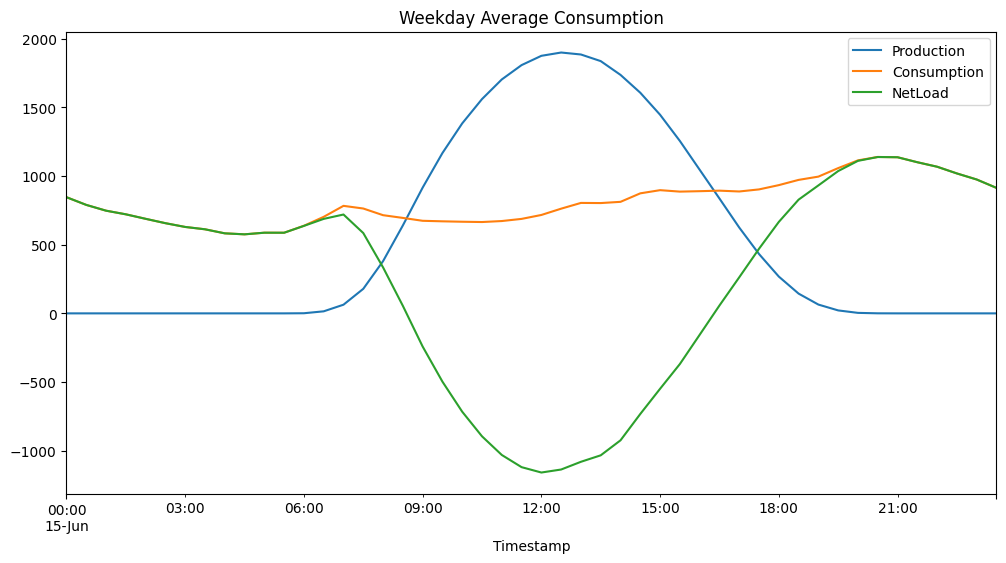

In [3]:
import matplotlib.pyplot as plt
_ = weekday_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Weekday Average Consumption', figsize=(12, 6))

**Optimization of Battery Size for Net Savings**

This optimization accounts for the price of batteries and finds the optimal battery size to save consumers money (for the specified sample of 3kW systems). This exists for both TOU tariffs and single-price tariffs. 

Information: https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
https://natec.com/wp-content/uploads/2020/12/6020-0205-Datasheet-LG-Chem-RESU-10H-High-Voltage-400V-type-C-for-SMA.pdf

**Single Price Tariff Optimization**

Although Cyprus uses Net-Metering, this study examines export energy that does not recieve remuneration

In [67]:
import scipy.optimize as spo
import numpy as np

BATT_PRICE_PER_WH = 0.127  # Euros per Wh (127 is what was found online)
max_charge_rate = 2500  # Max charge rate in Wh / 30 mins (power)
max_discharge_rate = 2500  # Max discharge rate in Wh / 30 mins (power)
soc_min = 0.05  # Maximum Depth of Discharge 95%
soc_max = 1.00  # Maximum State of Charge 100%; can play around with to protect battery
sqrt_eff = 0.98  # round trip Efficiency of the battery
import_tariff = 0.37  # Euro per Wh; this is avg. for Cyprus but can play with this
self_discharge = 0.05  # 5% self discharge per day; totally made up
# self discharge percentage assuming 48 points per day; very rough estimate
self_discharge_per_point = self_discharge / 48


# returns the objective function; a function which returns the cost of the consumer
def get_objective(pred_net_load: np.array, duration: float):
    points = pred_net_load.shape[0]
    batt_duration = 365 * 15 / duration  # 10 years of battery life

    # Define the objective function
    def objective(x):
        batt_size = x[points]  # Battery size in kWh
        charge = x[
            :points
        ]  # Charge with positive for charging, neg for discharging (Wh)
        batt_price = (batt_size * BATT_PRICE_PER_WH) / batt_duration
        price = np.zeros(points)

        for t in range(points):
            price[t] = (
                max(0, pred_net_load[t] + (charge[t] if charge[t] > 0 else charge[t] * sqrt_eff))
                * import_tariff
                * 0.5  # 0.5 due to time period
            )
        return np.sum(price) + batt_price

    return objective


# Get SOC
def calc_soc(x, points):
    batt_size = x[points]
    charge = x[:points]
    soc = np.zeros(points + 1)
    soc[0] = soc_min

    for t in range(points):
        soc[t + 1] = (
            soc[t]
            + (((charge[t] * sqrt_eff) if charge[t] > 0 else charge[t]) / batt_size)
            - (self_discharge_per_point * soc[t])
        )
    return soc


# returns constraint list; x is power out of ESS (positive for discharge, negative for charge)
def get_local_constraints(pred_net_load: np.array):
    points = pred_net_load.shape[0]

    # Define the Soc Constraint
    def soc_constraint(x):
        soc = calc_soc(x, points)
        return soc_max - soc, soc - soc_min

    return [
        {"type": "ineq", "fun": lambda x: soc_constraint(x)[0]},
        {"type": "ineq", "fun": lambda x: soc_constraint(x)[1]},
    ]


# Perform the optimization; duration is optimized days (in days)
def local_optimize(pred_net_load: np.array, duration, method: str = "SLSQP"):
    x0 = np.zeros(pred_net_load.shape[0] + 1)
    x0[-1] = 1  # Initial guess for battery size in Wh; prevents divide by zero
    bounds = [((-1 * max_discharge_rate), max_charge_rate) for _ in range(pred_net_load.shape[0])] + [
        (1, 10000)
    ]
    result = spo.minimize(
        get_objective(pred_net_load, duration),
        x0,
        bounds=bounds,
        method=method,
        constraints=get_local_constraints(pred_net_load),
        options={"maxiter": 4000, "disp": True},
    )

    return result


def get_global_constraints(points):
    # Define the Soc Constraint
    def soc_constraint(x):
        batt_size = x[points]
        soc = calc_soc(x, points)

        return soc_max * batt_size - soc, soc - batt_size * soc_min

    return spo.NonlinearConstraint(
        lambda x: soc_constraint(x)[0], 0, np.inf
    ), spo.NonlinearConstraint(lambda x: soc_constraint(x)[1], 0, np.inf)


# Perform the optimization globally; duration is optimized days (in days)
def global_optimize(pred_net_load: np.array, duration):
    points = pred_net_load.shape[0]
    bounds = [((-1 * max_discharge_rate), max_charge_rate) for _ in range(points)] + [
        (0, 10000)
    ]

    result = spo.differential_evolution(
        get_objective(pred_net_load, duration),
        bounds=bounds,
        constraints=get_global_constraints(points),
        workers=-1
    )

    return result
    

In [28]:
# Attempt at bi-level optimization
# returns the objective function; x is power out of ESS (positive for discharge, negative for charge)
def get_objective(pred_net_load: np.array):
    # Define the objective function
    def objective(x):
        price = np.zeros(pred_net_load.shape[0])

        for t in range(pred_net_load.shape[0]):
            price[t] = (
                max(0, pred_net_load[t] + (x[t] if x[t] > 0 else (x[t] * sqrt_eff)))
                * import_tariff
                * 0.5  # 0.5 due to time period
            )

        return np.sum(price)

    return objective

# calc soc for bi-level optimization
def calc_soc_bi_level(x, points, batt_size):
    soc = np.zeros(points + 1)
    soc[0] = soc_min

    for t in range(points):
        soc[t + 1] = (
            soc[t]
            + (((x[t] * sqrt_eff) if (x[t] > 0) else x[t]) / batt_size)
            - (self_discharge_per_point * soc[t])
        )
    return soc
# returns constraint list; x is power out of ESS (positive for discharge, negative for charge)
def get_constraints(pred_net_load: np.array, batt_size):
    points = pred_net_load.shape[0]
    # Define the Soc Constraint
    def soc_constraint(x):
        soc = calc_soc_bi_level(x, points, batt_size)
        return soc_max - soc, soc - soc_min

    # Define battery max charge constraint
    def charge_constraint(x):
        return (max_charge_rate - x), (max_discharge_rate + x)
    
    return [
        {"type": "ineq", "fun": lambda x: soc_constraint(x)[0]},
        {"type": "ineq", "fun": lambda x: soc_constraint(x)[1]},
        {"type": "ineq", "fun": lambda x: charge_constraint(x)[0]},
        {"type": "ineq", "fun": lambda x: charge_constraint(x)[1]}
    ]

# Perform the optimization
def optimize(pred_net_load: np.array, method: str = "SLSQP"):
    x0 = np.zeros(pred_net_load.shape[0])
    
    result = spo.minimize(
        get_objective(pred_net_load),
        x0,
        method=method,
        constraints=get_constraints(pred_net_load, 2000),
        options={'maxiter': 4000, 'disp': True}
    )
    return result

# Try bi-level optimization with battery size as outer and charge as inner
#def bi_level_optimize(pred_net_load: np.array, duration, method: str = "SLSQP"):

In [66]:
net_load = weekday_avg['NetLoad'].values
result = local_optimize(net_load, 1)
result.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 269.3589545001048
            Iterations: 73
            Function evaluations: 3683
            Gradient evaluations: 73


array([ 5.87508798e+01,  7.01979965e+01, -2.17285754e+01, -7.54068511e+00,
       -3.07528105e+00,  9.75616638e+00,  2.62542572e+01,  4.48203113e+01,
        5.49831400e+01, -5.42704516e+01, -4.06892066e+01, -2.80498516e+01,
       -4.45108901e+01, -3.17006266e+01, -1.60629927e+01, -1.89443336e+00,
        3.40357157e+00, -2.29084026e+00,  2.30823775e+02,  2.65126358e+02,
        7.14059685e+02,  8.85151269e+02,  8.95738119e+02,  8.96971891e+02,
        8.98053454e+02,  8.99252471e+02,  9.00600832e+02,  9.02032567e+02,
        9.01704164e+02,  7.25980943e+02,  2.75115832e+02,  2.76521108e+02,
        1.09370058e+02, -5.57187681e+01, -2.34876854e+02, -2.21988939e+02,
       -6.54436096e+02, -8.13416016e+02, -8.01611644e+02, -7.89303325e+02,
       -7.73832769e+02, -7.60736906e+02, -7.47514674e+02, -7.34660441e+02,
       -7.23167913e+02, -7.10268233e+02, -6.97464392e+02, -6.84316436e+02,
        9.99999628e+03])

9999.996280626307


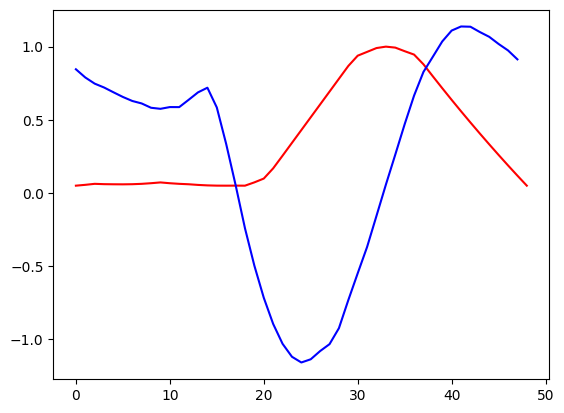

In [68]:
from turtle import color


print(result.x[-1])
plt.plot(calc_soc(result.x, len(result.x) - 1), color='red')
plt.plot(net_load / 1000, color='blue')

In [61]:
# Compare costs: 
price_func = get_objective(net_load, 1)
print(price_func(np.zeros(result.x.shape[0] + 1)))
print(price_func(result.x))

4392.133709896003
2689.9116181321688
